Task: https://phabricator.wikimedia.org/T367400

Description: Initial exploration of Automoderator's activity on testwiki.

## Setup

In [252]:
import pandas as pd
import wmfdata as wmf

import matplotlib.pyplot as plt
import seaborn as sns

from warnings import filterwarnings
def ig_warn(): filterwarnings('ignore')

In [147]:
pd.options.display.max_columns = None

In [148]:
wiki_db = 'testwiki'
am_username = 'AutoModeratorTest'

## EDA

### Set 1
- number of edits reverted by Automoderator (absolute)
- percentage of AM revert's reverted back
- average time taken for AM to revert an edit
- average time taken AM's revert to reverted back
- distribution of edit buckets of who edits did AM revert
- distribution of edit buckets of user's who reverted AM's reverts

Various prefixes have been adoped to differentiate and identify tables being joined, selection of variables etc.
- `amr_` prefix refers to Automoderator's revert.
    - for example: `amr_rev_id` refers to the revision id of the Automoderator's revert.
- revr_ prefix refers to the edit reverted by Automoderator
    - for example: `revr_rev_id` refers to the revision id of the edit which Automoderator reverted i.e. `rev_parent_id` of `rev_id` of Automoderator's revert
- revam_ prefix refer to the edit that reverted Automoderator's revert
    - for example: `revam_rev_id` referes to the revision id of the edit which reverted Automoderator's revert i.e. `revam_rev_id`'s `rev_parent_id` should be equal to amr_rev_id 

In [209]:
ig_warn()

query = f"""
WITH
    base AS (
        SELECT
            
            -- details of revert performed by Automoderator
            amr_r.rev_timestamp AS amr_rev_ts,
            DATE(amr_r.rev_timestamp) AS amr_rev_dt,
            amr_r.rev_id AS amr_rev_id,
            amr_r.rev_page AS amr_page_id,
            amr_ct_def.ctd_name AS amr_rev_tag,

            -- id of the revision being reverted
            amr_r.rev_parent_id AS amr_rev_parent_id, 
            
            -- details of the edit which Automoderator reverted
            revr_r.rev_id AS revr_rev_id, -- should be equal to amr_rev_parent_id
            UNIX_TIMESTAMP(amr_r.rev_timestamp) - UNIX_TIMESTAMP(revr_r.rev_timestamp) AS amr_time_to_revert_secs,
            CASE
                WHEN revr_a.actor_user IS NULL THEN 'anonymous'
                WHEN 
                    revr_a.actor_user IS NOT NULL 
                    AND revr_u.user_editcount <= 50 
                    AND ((UNIX_TIMESTAMP(CURRENT_TIMESTAMP) - UNIX_TIMESTAMP(revr_u.user_registration)) / (3600*24)) <= 30 
                THEN 'newcomer'
                ELSE 'misc'
            END AS revr_user_type,
            CASE
                WHEN revr_a.actor_user IS NULL THEN NULL
                WHEN revr_a.actor_user IS NOT NULL AND revr_u.user_editcount BETWEEN 1 AND 5 THEN '1-5'
                WHEN revr_a.actor_user IS NOT NULL AND revr_u.user_editcount BETWEEN 6 AND 99 THEN '6-99'
                WHEN revr_a.actor_user IS NOT NULL AND revr_u.user_editcount BETWEEN 100 AND 999 THEN '100-999'
                WHEN revr_a.actor_user IS NOT NULL AND revr_u.user_editcount BETWEEN 1000 AND 4999 THEN '1000-4999'
                WHEN revr_a.actor_user IS NOT NULL AND revr_u.user_editcount > 5000 THEN '5000+'
                ELSE 'misc'
            END AS revr_user_edit_bucket,
            -- details of the edit which reverted Automoderator's revert, if applicable
            CASE WHEN
                revam_r.rev_id IS NOT NULL THEN TRUE
                ELSE FALSE
            END AS amr_is_reverted,
            CASE
                WHEN NOT revam_r.rev_id IS NOT NULL THEN NULL
                WHEN revam_a.actor_user IS NULL THEN 'anonymous'
                WHEN 
                    revam_a.actor_user IS NOT NULL 
                    AND revam_u.user_editcount <= 50 
                    AND  ((UNIX_TIMESTAMP(CURRENT_TIMESTAMP) - UNIX_TIMESTAMP(revam_u.user_registration)) / (3600*24)) <= 30 
                THEN 'newcomer'
                ELSE 'misc'
            END AS revam_user_type,
            CASE
                WHEN revam_a.actor_user IS NULL THEN NULL
                WHEN revam_a.actor_user IS NOT NULL AND revam_u.user_editcount BETWEEN 1 AND 5 THEN '1-5'
                WHEN revam_a.actor_user IS NOT NULL AND revam_u.user_editcount BETWEEN 6 AND 99 THEN '6-99'
                WHEN revam_a.actor_user IS NOT NULL AND revam_u.user_editcount BETWEEN 100 AND 999 THEN '100-999'
                WHEN revam_a.actor_user IS NOT NULL AND revam_u.user_editcount BETWEEN 1000 AND 4999 THEN '1000-4999'
                WHEN revam_a.actor_user IS NOT NULL AND revam_u.user_editcount > 5000 THEN '5000+'
                ELSE 'misc'
            END AS revam_user_edit_bucket,
            UNIX_TIMESTAMP(revam_r.rev_timestamp) - UNIX_TIMESTAMP(amr_r.rev_timestamp) AS revam_time_to_revert_secs,
            
            -- id of the revision of the page before reverted edit
            JSON_VALUE(amr_ct.ct_params, '$.originalRevisionId') AS tmp_reverted_to_rev_id,
            -- currently same as id of the revision being reverted (i.e rev_parent_id)
            JSON_VALUE(amr_ct.ct_params, '$.newestRevertedRevId') AS tmp_newest_revert_rev_id,
            JSON_VALUE(amr_ct.ct_params, '$.oldestRevertedRevId') AS tmp_oldest_revert_rev_id,
            JSON_VALUE(amr_ct.ct_params, '$.isExactRevert') AS amr_is_exact_revert
        FROM
            revision amr_r
        JOIN
            change_tag amr_ct
            ON amr_ct.ct_rev_id = amr_r.rev_id
        JOIN
            change_tag_def amr_ct_def
            ON amr_ct.ct_tag_id = amr_ct_def.ctd_id
        JOIN
            actor amr_a
            ON amr_r.rev_actor = amr_a.actor_id
        JOIN
            revision revr_r
            ON amr_r.rev_parent_id = revr_r.rev_id
        JOIN
            actor revr_a
            ON revr_r.rev_actor = revr_a.actor_id
        LEFT JOIN
            user revr_u
            ON revr_a.actor_user = revr_u.user_id
        LEFT JOIN
            revision revam_r
            ON amr_r.rev_id = revam_r.rev_parent_id
        LEFT JOIN
            actor revam_a
            ON revam_r.rev_actor = revam_a.actor_id
        LEFT JOIN
            user revam_u
            ON revam_a.actor_user = revam_u.user_id
        WHERE
            amr_ct_def.ctd_name IN ('mw-undo', 'mw-rollback', 'mw-manual-revert')
            AND amr_a.actor_name = '{am_username}'
    )

SELECT
    *
FROM
    base
ORDER BY
    amr_rev_ts DESC
"""

am_reverts = wmf.mariadb.run(query, dbs='testwiki', date_col=['amr_rev_ts', 'amr_rev_dt'])
am_reverts

amr_rev_ts amr_rev_dt  amr_rev_id  amr_page_id amr_rev_tag  \
0 2024-06-10 08:21:22 2024-06-10      597552       122032     mw-undo   
1 2024-06-10 08:15:07 2024-06-10      597546       114026     mw-undo   
2 2024-06-04 22:54:33 2024-06-04      597269       153522     mw-undo   
3 2024-06-04 12:39:59 2024-06-04      597215       148062     mw-undo   
4 2024-06-04 12:34:57 2024-06-04      597213       148062     mw-undo   
5 2024-05-26 03:57:43 2024-05-26      596347       114054     mw-undo   
6 2024-05-26 03:54:44 2024-05-26      596342       155073     mw-undo   
7 2024-05-24 13:12:59 2024-05-24      595945        82485     mw-undo   
8 2024-05-24 13:03:28 2024-05-24      595941        82485     mw-undo   

   amr_rev_parent_id  revr_rev_id  amr_time_to_revert_secs revr_user_type  \
0             597551       597551                      0.0           misc   
1             597545       597545                      1.0           misc   
2             597268       597268                      1.0           misc   
3             597214       597214                      1.0       newcomer   
4             597212       597212                      1.0      anonymous   
5             596346       596346                     61.0       newcomer   
6             596341       596341                     61.0       newcomer   
7             595944       595944                      1.0       newcomer   
8             595940       595940                      1.0      anonymous   

  revr_user_edit_bucket  amr_is_reverted revam_user_type  \
0                  6-99                0            None   
1                  6-99                1            misc   
2                  6-99                1            misc   
3                   1-5                0            None   
4                  None                1        newcomer   
5                  6-99                0            None   
6                  6-99                1        newcomer   
7                   1-5                0            None   
8                  None                1       anonymous   

  revam_user_edit_bucket  revam_time_to_revert_secs tmp_reverted_to_rev_id  \
0                   None                        NaN                 590939   
1                   6-99                       52.0                 497115   
2                   6-99                   465754.0                 595066   
3                   None                        NaN                 597213   
4                    1-5                      301.0                 597211   
5                   None                        NaN                 577797   
6                   6-99                        7.0                 595881   
7                   None                        NaN                 595943   
8                   None                      453.0                 595939   

  tmp_newest_revert_rev_id tmp_oldest_revert_rev_id amr_is_exact_revert  
0                   597551                   597551                   1  
1                   597545                   597545                   1  
2                   597268                   597268                   1  
3                   597214                   597214                   1  
4                   597212                   597212                   1  
5                   596346                   596346                   1  
6                   596341                   596341                   1  
7                   595944                   595944                   1  
8                   595940                   595940                   1

In [175]:
print('Reverts by Automoderator, daily')
am_daily_reverts = (        
    am_reverts
    .groupby('amr_rev_dt')
    .agg(am_reverts_count=('amr_rev_id', 'count'))
    .reset_index()
)
am_daily_reverts

Reverts by Automoderator, daily


amr_rev_dt  am_reverts_count
0 2024-05-24                 2
1 2024-05-26                 2
2 2024-06-04                 3
3 2024-06-10                 2

In [178]:
print('Proportion of AM\'s revert reverted back')
am_reverts.amr_is_reverted.value_counts()

Proportion of AM's revert reverted back


amr_is_reverted
1    5
0    4
Name: count, dtype: int64

In [200]:
print(f'Average time (seconds) for AM to revert an edit: {am_reverts.amr_time_to_revert_secs.mean()} seconds') 
print(f'Median time (seconds) for AM to revert an edit: {am_reverts.amr_time_to_revert_secs.median()} seconds') 

Average time (seconds) for AM to revert an edit: 14.222222222222221 seconds
Median time (seconds) for AM to revert an edit: 1.0 seconds


In [198]:
print(f'Average time (seconds) for AM\'s revert to reverted (if applicable): {am_reverts.revam_time_to_revert_secs.mean()} seconds') 
print(f'Median time (seconds) for AM to revert an edit (if applicable): {am_reverts.revam_time_to_revert_secs.median()} seconds')

Average time (seconds) for AM's revert to reverted (if applicable): 93313.4 seconds
Median time (seconds) for AM to revert an edit: 301.0 seconds


In [201]:
print('Distribution of user types whose edit was reverted by AM')
am_reverts.revr_user_type.value_counts()

Distribution of user types whose edit was reverted by AM


revr_user_type
newcomer     4
misc         3
anonymous    2
Name: count, dtype: int64

In [212]:
print('Distribution of user edit bucket whose edit was reverted by AM')
am_reverts.revr_user_edit_bucket.value_counts()

Distribution of user edit bucket whose edit was reverted by AM


revr_user_edit_bucket
6-99    5
1-5     2
Name: count, dtype: int64

In [214]:
print('Distribution of user types who reverted AM\'s revert')
am_reverts.revam_user_type.value_counts()

Distribution of user types who reverted AM's revert


revam_user_type
misc         2
newcomer     2
anonymous    1
Name: count, dtype: int64

In [213]:
print('Distribution of user edit bucket who reverted AM\'s revert')
am_reverts.revam_user_edit_bucket.value_counts()

Distribution of user edit bucket who reverted AM's revert


revam_user_edit_bucket
6-99    3
1-5     1
Name: count, dtype: int64

### Set 2

- proportion of edits reverted by performer

In [236]:
query = f"""
WITH
    base AS (
        SELECT
            rev_id,
            rev_timestamp,
            DATE(rev_timestamp) AS rev_dt,
            ctd_name,
            CASE
                WHEN a.actor_name = '{am_username}' THEN TRUE
                ELSE FALSE
            END AS is_am_revert,
            CASE
                WHEN a.actor_user IS NULL THEN TRUE
                ELSE FALSE
            END AS is_anon_revert,
            CASE
                WHEN a.actor_user IS NULL OR a.actor_name = '{am_username}' THEN NULL
                WHEN (NOT (a.actor_user IS NULL OR a.actor_name = '{am_username}')) AND u.user_editcount BETWEEN 1 AND 5 THEN 'ueb_1'
                WHEN (NOT (a.actor_user IS NULL OR a.actor_name = '{am_username}')) AND u.user_editcount BETWEEN 6 AND 99 THEN 'ueb_2'
                WHEN (NOT (a.actor_user IS NULL OR a.actor_name = '{am_username}')) AND u.user_editcount BETWEEN 100 AND 999 THEN 'ueb_3'
                WHEN (NOT (a.actor_user IS NULL OR a.actor_name = '{am_username}')) AND u.user_editcount BETWEEN 1000 AND 4999 THEN 'ueb_4'
                WHEN (NOT (a.actor_user IS NULL OR a.actor_name = '{am_username}')) AND u.user_editcount > 5000 THEN 'ueb_5'
                ELSE 'misc'
            END AS rev_user_edit_bucket            
        FROM
            revision r
        JOIN
            actor a
            ON r.rev_actor = a.actor_id
        JOIN
            user u 
            ON a.actor_user = u.user_id
        JOIN
            page p 
            ON r.rev_page = p.page_id
        JOIN
            change_tag ct
            ON r.rev_id = ct.ct_rev_id
        JOIN
            change_tag_def ctd
            ON ct.ct_tag_id = ctd.ctd_id
        WHERE
            ctd_name IN ('mw-undo', 'mw-rollback', 'mw-manual-revert')
            AND year(rev_timestamp) >= 2023
            AND page_namespace = 0
    ),
    
    grouped AS (
        SELECT 
            rev_dt,
            is_am_revert,
            is_anon_revert,
            rev_user_edit_bucket,
            COUNT(DISTINCT rev_id) AS n_reverts
        FROM 
            base
        GROUP BY
            rev_dt,
            is_anon_revert,
            rev_user_edit_bucket,
            rev_user_edit_bucket
    )

SELECT
    rev_dt,
    SUM(CASE WHEN is_am_revert THEN n_reverts ELSE 0 END) AS am_reverts,
    SUM(CASE WHEN rev_user_edit_bucket = 'ueb_1' THEN n_reverts ELSE 0 END) AS ueb_1,
    SUM(CASE WHEN rev_user_edit_bucket = 'ueb_2' THEN n_reverts ELSE 0 END) AS ueb_2,
    SUM(CASE WHEN rev_user_edit_bucket = 'ueb_3' THEN n_reverts ELSE 0 END) AS ueb_3,
    SUM(CASE WHEN rev_user_edit_bucket = 'ueb_4' THEN n_reverts ELSE 0 END) AS ueb_4,
    SUM(CASE WHEN rev_user_edit_bucket = 'ueb_5' THEN n_reverts ELSE 0 END) AS ueb_5,
    SUM(CASE WHEN is_anon_revert THEN n_reverts ELSE 0 END) AS anon_reverts
FROM
    grouped
GROUP BY
    rev_dt
ORDER BY
    rev_dt  
"""

all_reverts = wmf.mariadb.run(query, dbs='testwiki', date_col=['rev_dt'])
all_reverts['month'] = all_reverts.rev_dt.dt.to_period('M')
all_reverts.head()

rev_dt  am_reverts  ueb_1  ueb_2  ueb_3  ueb_4  ueb_5  anon_reverts  \
0 2023-01-06         0.0    0.0    2.0    0.0    0.0    0.0           0.0   
1 2023-01-10         0.0    0.0    1.0    0.0    0.0    0.0           0.0   
2 2023-01-12         0.0    0.0    0.0    0.0    2.0    0.0           0.0   
3 2023-01-17         0.0    0.0    0.0    0.0    8.0    0.0           0.0   
4 2023-01-18         0.0    0.0    0.0    1.0    2.0    0.0           0.0   

     month  
0  2023-01  
1  2023-01  
2  2023-01  
3  2023-01  
4  2023-01

In [274]:
reverts_pivot = (
    all_reverts
    .drop('rev_dt', axis=1)
    .groupby('month')
    .sum()
    .assign(
        all_reverts=lambda df: df.sum(axis=1),
        user_reverts=lambda df: df[[col for col in df.columns if col.startswith('ueb_')]].sum(axis=1),
        am_reverts_pct=lambda df: round(df['am_reverts'] / df['all_reverts'] * 100, 2),
        user_reverts_pct=lambda df: round(df['user_reverts'] / df['all_reverts'] * 100, 2),
        anon_reverts_pct=lambda df: round(df['anon_reverts'] / df['all_reverts'] * 100, 2)
    )
    .reset_index()
    .assign(
        month=lambda df: pd.to_datetime(df['month'].apply(lambda x: x.to_timestamp() if hasattr(x, 'to_timestamp') else x))
    )
)
reverts_pivot.head()

month  am_reverts  ueb_1  ueb_2  ueb_3  ueb_4  ueb_5  anon_reverts  \
0 2023-01-01         0.0    1.0    7.0   10.0   13.0    0.0           0.0   
1 2023-02-01         0.0    0.0    6.0   17.0   54.0    1.0           0.0   
2 2023-03-01         0.0    4.0   23.0   19.0    1.0    0.0           0.0   
3 2023-04-01         0.0    0.0    7.0    3.0   79.0    0.0           0.0   
4 2023-05-01         0.0    1.0   45.0   20.0   15.0    0.0           0.0   

   all_reverts  user_reverts  am_reverts_pct  user_reverts_pct  \
0         31.0          31.0             0.0             100.0   
1         78.0          78.0             0.0             100.0   
2         47.0          47.0             0.0             100.0   
3         89.0          89.0             0.0             100.0   
4         81.0          81.0             0.0             100.0   

   anon_reverts_pct  
0               0.0  
1               0.0  
2               0.0  
3               0.0  
4               0.0

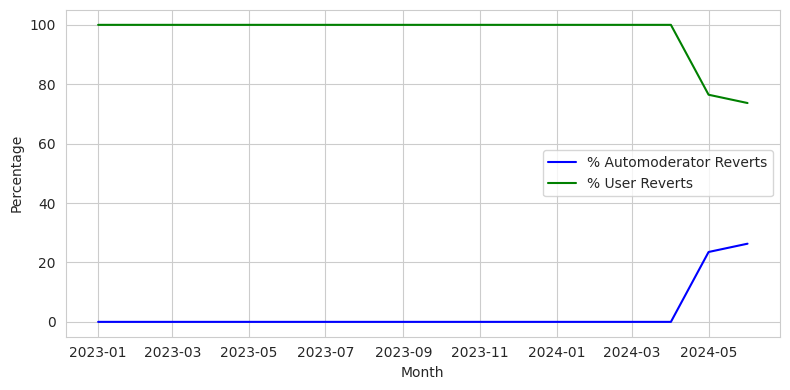

In [290]:
plt.figure(figsize=(8, 4))
sns.set_style('whitegrid')

sns.lineplot(data=reverts_pivot, x='month', y='am_reverts_pct', label='% Automoderator Reverts', color='blue')
sns.lineplot(data=reverts_pivot, x='month', y='user_reverts_pct', label='% User Reverts', color='green')

plt.ylabel('Percentage')
plt.xlabel('Month')
# plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

### ct_params

In [215]:
wmf.mariadb.run("""
SELECT
    rev_id,
    rev_page,
    rev_sha1,
    ctd_name,
    JSON_VALUE(ct_params, '$.originalRevisionId') AS reverted_to_rev_id,
    JSON_VALUE(ct_params, '$.newestRevertedRevId') AS newest_revert_rev_id,
    JSON_VALUE(ct_params, '$.oldestRevertedRevId') AS oldest_revert_rev_id,
    JSON_VALUE(ct_params, '$.isExactRevert') AS is_exact_revert
FROM
    revision
JOIN
    actor
    ON rev_actor = actor_id
JOIN
    change_tag
    ON ct_rev_id = rev_id
JOIN
    change_tag_def
    ON ct_tag_id = ctd_id
WHERE
    ctd_name IN ('mw-undo', 'mw-rollback', 'mw-manual-revert')
    AND actor_name = 'AutoModeratorTest'

""", 'testwiki')

rev_id  rev_page                         rev_sha1 ctd_name  \
0  595941     82485  3xlq8jz2un8ibk04bierotbb94v2g12  mw-undo   
1  595945     82485  0drmpqif86dftk6chxk5idyfjir0jwp  mw-undo   
2  596342    155073  st9xeqnz82p9k0qppi65gtp15hyosvp  mw-undo   
3  596347    114054  hnwu27ziwxejnpohwcten0wqj91m986  mw-undo   
4  597213    148062  8sq8u97h5gpjdj90wkep6fej8hvdpzn  mw-undo   
5  597215    148062  8sq8u97h5gpjdj90wkep6fej8hvdpzn  mw-undo   
6  597269    153522  daee60u2qio9guad6xkhfvhrcg3g2gp  mw-undo   
7  597546    114026  tnfbkqdtz0y9lwnbuzwdptdo3ytdilb  mw-undo   
8  597552    122032  10znqnqalpikgj0tuolq1e6926jhrp5  mw-undo   

  reverted_to_rev_id newest_revert_rev_id oldest_revert_rev_id is_exact_revert  
0             595939               595940               595940               1  
1             595943               595944               595944               1  
2             595881               596341               596341               1  
3             577797               596346               596346               1  
4             597211               597212               597212               1  
5             597213               597214               597214               1  
6             595066               597268               597268               1  
7             497115               597545               597545               1  
8             590939               597551               597551               1

Notes:

- AM will not revert back if someone reverts back its reverts (especially if it is the same user.)
- If there is a rev_parent_id for AM-revert's rev_id, it can be considered the AM's revert has not been reverted back
    - If AM's revert is reverted back then a future revision will have AM revert's rev_id matching to it's rev_parent_id